# Brain Tumor MRI Classification – GNN

This notebook trains a **Graph Neural Network (GCN via PyTorch Geometric)** on the Brain Tumor MRI Dataset – Merged (4 classes).
- Shared preprocessing: grayscale, resize to 64×64, normalize
- Train/val split with stratification
- Metrics: Accuracy, F1-score, Confusion Matrix; plus learning curves

> Set `DATA_DIR` to your dataset root (with subfolders: `glioma/`, `meningioma/`, `pituitary/`, `no_tumor/`).

**Note:** This notebook uses **PyTorch** and **PyTorch Geometric** (PyG). Install per your Torch/CUDA version:
```bash
pip install torch torchvision torchaudio
# Then (CPU example):
pip install torch-geometric pyg-lib torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
```

Torch: 2.8.0+cpu Device: cpu
Total images: 13351
Train: 10680 Val: 2671
Total images: 13351
Train: 10680 Val: 2671
Epoch 01 | Train Acc 0.339 Loss 1.333 | Val Acc 0.417 Loss 1.236
Epoch 01 | Train Acc 0.339 Loss 1.333 | Val Acc 0.417 Loss 1.236
Epoch 02 | Train Acc 0.401 Loss 1.244 | Val Acc 0.438 Loss 1.191
Epoch 02 | Train Acc 0.401 Loss 1.244 | Val Acc 0.438 Loss 1.191
Epoch 03 | Train Acc 0.416 Loss 1.221 | Val Acc 0.440 Loss 1.174
Epoch 03 | Train Acc 0.416 Loss 1.221 | Val Acc 0.440 Loss 1.174
Epoch 04 | Train Acc 0.415 Loss 1.213 | Val Acc 0.437 Loss 1.168
Epoch 04 | Train Acc 0.415 Loss 1.213 | Val Acc 0.437 Loss 1.168
Epoch 05 | Train Acc 0.416 Loss 1.214 | Val Acc 0.434 Loss 1.164
Epoch 05 | Train Acc 0.416 Loss 1.214 | Val Acc 0.434 Loss 1.164
Epoch 06 | Train Acc 0.418 Loss 1.211 | Val Acc 0.437 Loss 1.162
Epoch 06 | Train Acc 0.418 Loss 1.211 | Val Acc 0.437 Loss 1.162
Epoch 07 | Train Acc 0.439 Loss 1.204 | Val Acc 0.507 Loss 1.146
Epoch 07 | Train Acc 0.439 Loss 1.204 | 

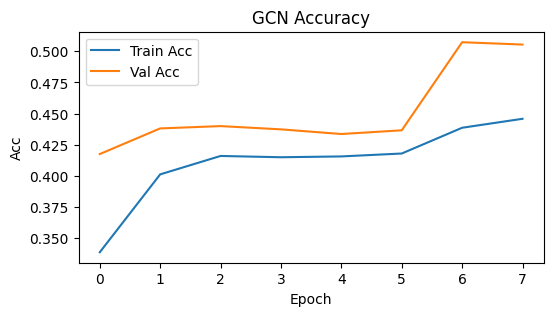

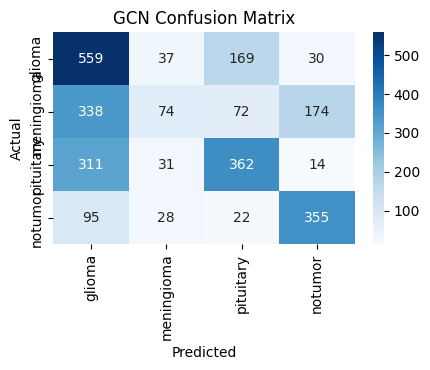

              precision    recall  f1-score   support

      glioma       0.43      0.70      0.53       795
  meningioma       0.44      0.11      0.18       658
   pituitary       0.58      0.50      0.54       718
     notumor       0.62      0.71      0.66       500

    accuracy                           0.51      2671
   macro avg       0.52      0.51      0.48      2671
weighted avg       0.51      0.51      0.47      2671

Weighted F1: 0.4714248238958583


In [2]:
# --- Imports (PyTorch / PyG) ---
import os, pathlib, numpy as np, matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import seaborn as sns
import torch
import torch.nn as nn
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool

torch.manual_seed(42)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Torch:", torch.__version__, "Device:", DEVICE)

DATA_DIR = "../data"
IMG_SIZE = 32  # keep graphs smaller (32x32 => 1024 nodes per image)
classes = ["glioma", "meningioma", "pituitary", "notumor"]
class_to_idx = {c:i for i,c in enumerate(classes)}

# Collect image paths
data_root = pathlib.Path(DATA_DIR)
image_paths, labels = [], []
for c in classes:
    for p in (data_root / c).glob("*"):
        if p.suffix.lower() in {".jpg",".jpeg",".png",".bmp"}:
            image_paths.append(str(p))
            labels.append(class_to_idx[c])
print("Total images:", len(image_paths))

# Train/val split
X_train, X_val, y_train, y_val = train_test_split(image_paths, labels, test_size=0.2, random_state=42, stratify=labels)
print("Train:", len(X_train), "Val:", len(X_val))

# Precompute 4-neighbor edge index for IMG_SIZE x IMG_SIZE grid
edges = []
for i in range(IMG_SIZE):
    for j in range(IMG_SIZE):
        nid = i*IMG_SIZE + j
        if i>0: edges.append([nid, nid-IMG_SIZE])
        if i<IMG_SIZE-1: edges.append([nid, nid+IMG_SIZE])
        if j>0: edges.append([nid, nid-1])
        if j<IMG_SIZE-1: edges.append([nid, nid+1])
import numpy as np
edge_index = torch.tensor(np.array(edges, dtype=np.int64).T, dtype=torch.long)  # [2, E]

class MRIGraphs(Dataset):
    def __init__(self, paths, ys, transform=None):
        super().__init__()
        self.paths = paths; self.ys = ys; self.transform = transform
    def len(self): return len(self.paths)
    def get(self, idx):
        im = Image.open(self.paths[idx]).convert("L").resize((IMG_SIZE, IMG_SIZE))
        arr = np.asarray(im, dtype=np.float32)/255.0
        x = torch.tensor(arr.reshape(-1,1), dtype=torch.float)  # [N,1]
        y = torch.tensor(self.ys[idx], dtype=torch.long)
        return Data(x=x, edge_index=edge_index, y=y)

train_ds = MRIGraphs(X_train, y_train)
val_ds = MRIGraphs(X_val, y_val)
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False)

# Define a small GCN
class BrainGCN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(1, 16)
        self.conv2 = GCNConv(16, 32)
        self.fc1 = nn.Linear(32, 16)
        self.fc2 = nn.Linear(16, 4)
    def forward(self, x, edge_index, batch):
        x = torch.relu(self.conv1(x, edge_index))
        x = torch.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)  # [batch, 32]
        x = torch.relu(self.fc1(x))
        x = nn.functional.dropout(x, p=0.5, training=self.training)
        return self.fc2(x)

model = BrainGCN().to(DEVICE)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
crit = nn.CrossEntropyLoss()

def run_epoch(loader, train=True):
    if train: model.train()
    else: model.eval()
    total_loss, correct, total = 0.0, 0, 0
    for batch in loader:
        batch = batch.to(DEVICE)
        if train: opt.zero_grad()
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = crit(out, batch.y)
        if train:
            loss.backward(); opt.step()
        total_loss += loss.item() * batch.num_graphs
        pred = out.argmax(1)
        correct += int((pred == batch.y).sum())
        total += batch.num_graphs
    return total_loss/total, correct/total

EPOCHS = 8
hist = {"tr_acc":[], "va_acc":[], "tr_loss":[], "va_loss":[]}
for ep in range(1, EPOCHS+1):
    tl, ta = run_epoch(train_loader, train=True)
    vl, va = run_epoch(val_loader, train=False)
    hist["tr_loss"].append(tl); hist["va_loss"].append(vl)
    hist["tr_acc"].append(ta); hist["va_acc"].append(va)
    print(f"Epoch {ep:02d} | Train Acc {ta:.3f} Loss {tl:.3f} | Val Acc {va:.3f} Loss {vl:.3f}")

# Curves
plt.figure(figsize=(6,3))
plt.plot(hist["tr_acc"], label="Train Acc")
plt.plot(hist["va_acc"], label="Val Acc")
plt.title("GCN Accuracy"); plt.xlabel("Epoch"); plt.ylabel("Acc"); plt.legend(); plt.show()

# Validation predictions & CM
all_preds, all_lbls = [], []
model.eval()
for batch in val_loader:
    batch = batch.to(DEVICE)
    with torch.no_grad():
        out = model(batch.x, batch.edge_index, batch.batch)
    all_preds.extend(out.argmax(1).cpu().numpy().tolist())
    all_lbls.extend(batch.y.cpu().numpy().tolist())

cm = confusion_matrix(all_lbls, all_preds)
plt.figure(figsize=(4.5,3.8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.title("GCN Confusion Matrix"); plt.ylabel("Actual"); plt.xlabel("Predicted"); plt.tight_layout(); plt.show()

print(classification_report(all_lbls, all_preds, target_names=classes))
print("Weighted F1:", f1_score(all_lbls, all_preds, average="weighted"))